In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
statcoefvar_dic = {
    'Run Time': [],
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1-Score': []
}

indaccs = {}

In [7]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    #X_train = subject_df.loc[train_index, ["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
    #X_test = subject_df.loc[test_index, ["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
    #Y_train = subject_df.loc[train_index, "rhythmLabel"]
    #Y_test = subject_df.loc[test_index, "rhythmLabel"]
    
    X_train = subject_df.iloc[train_index, 13].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 13].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statcoefvar_dic['Run Time'].append(elapsed)
statcoefvar_dic['Accuracy'].append(np.mean(acc_score))
statcoefvar_dic['Standard Error'].append(np.std(acc_score))
statcoefvar_dic['Sensitivity'].append(sensitivity)
statcoefvar_dic['Specificity'].append(specificity)
statcoefvar_dic['Precision'].append(precision)
statcoefvar_dic['F1-Score'].append(f1_score)

indaccs['LogReg'] = acc_score

---Run time is 0.37440353200000054 seconds ---

Accuracy of each fold: 
 [0.8722847018949315, 0.8731895223420647, 0.8770416024653312, 0.875808936825886, 0.8805855161787365]
Avg accuracy: 0.8757820559413899
Std of accuracy : 
0.0029534090834018576

[[17142  2284]
 [ 1747 11278]]

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     19426
           1       0.83      0.87      0.85     13025

    accuracy                           0.88     32451
   macro avg       0.87      0.87      0.87     32451
weighted avg       0.88      0.88      0.88     32451

0.882425615154947
0.865873320537428
0.907512308751125
0.8947931619470182


In [8]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []


for train_index, test_index in kf.split(subject_df):
  
    X_train = subject_df.iloc[train_index, 13].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 13].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    
    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statcoefvar_dic['Run Time'].append(elapsed)
statcoefvar_dic['Accuracy'].append(np.mean(acc_score))
statcoefvar_dic['Standard Error'].append(np.std(acc_score))
statcoefvar_dic['Sensitivity'].append(sensitivity)
statcoefvar_dic['Specificity'].append(specificity)
statcoefvar_dic['Precision'].append(precision)
statcoefvar_dic['F1-Score'].append(f1_score)

indaccs['LDA'] = acc_score

---Run time is 0.8716371079999998 seconds ---

Accuracy of each fold: 
 [0.8745955938992451, 0.8738058551617873, 0.8778120184899846, 0.8767334360554699, 0.8853620955315871]
Avg accuracy: 0.8776617998276148
Std of accuracy : 
0.004109717920482175

[[16997  2429]
 [ 1541 11484]]

              precision    recall  f1-score   support

           0       0.92      0.87      0.90     19426
           1       0.83      0.88      0.85     13025

    accuracy                           0.88     32451
   macro avg       0.87      0.88      0.87     32451
weighted avg       0.88      0.88      0.88     32451

0.8749613919489344
0.8816890595009597
0.9168734491315137
0.8954272468654515


In [9]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    
    X_train = subject_df.iloc[train_index, 13].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 13].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statcoefvar_dic['Run Time'].append(elapsed)
statcoefvar_dic['Accuracy'].append(np.mean(acc_score))
statcoefvar_dic['Standard Error'].append(np.std(acc_score))
statcoefvar_dic['Sensitivity'].append(sensitivity)
statcoefvar_dic['Specificity'].append(specificity)
statcoefvar_dic['Precision'].append(precision)
statcoefvar_dic['F1-Score'].append(f1_score)

indaccs['QDA'] = acc_score

---Run time is 1.6226193569999996 seconds ---

Accuracy of each fold: 
 [0.8736712370975196, 0.8736517719568567, 0.8775038520801233, 0.8764252696456086, 0.8827426810477658]
Avg accuracy: 0.8767989623655748
Std of accuracy : 
0.0033362188283389293

[[17065  2361]
 [ 1637 11388]]

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     19426
           1       0.83      0.87      0.85     13025

    accuracy                           0.88     32451
   macro avg       0.87      0.88      0.87     32451
weighted avg       0.88      0.88      0.88     32451

0.8784618552455472
0.8743186180422264
0.9124692546251738
0.8951426772975242


In [10]:
KNN_result = []
X=subject_df.iloc[:, 13].values.reshape(-1,1)
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)
print(np.max(KNN_result))

K=1

Accuracy of each fold: 
 [0.82714528 0.82003082 0.82141757 0.82942989 0.83112481]

Avg accuracy: 0.8258296719482873

K=2

Accuracy of each fold: 
 [0.80126329 0.79738059 0.79691834 0.80446841 0.80215716]

Avg accuracy: 0.8004375573717217

K=3

Accuracy of each fold: 
 [0.84147281 0.84884438 0.85192604 0.84853621 0.85839753]

Avg accuracy: 0.8498353937501232

K=4

Accuracy of each fold: 
 [0.8373132  0.84483821 0.84822804 0.84453005 0.84607088]

Avg accuracy: 0.8441960766347336

K=5

Accuracy of each fold: 
 [0.8567247  0.85731895 0.86224961 0.85932203 0.86887519]

Avg accuracy: 0.8608980978522116

K=6

Accuracy of each fold: 
 [0.85425974 0.85546995 0.85901387 0.85531587 0.86594761]

Avg accuracy: 0.8580014095610397

K=7

Accuracy of each fold: 
 [0.86458173 0.86394453 0.86594761 0.8651772  0.87411402]

Avg accuracy: 0.8667530175122173

K=8

Accuracy of each fold: 
 [0.8624249  0.86502311 0.8624037  0.86224961 0.87211094]

Avg accuracy: 0.8648424522374111

K=9

Accuracy of each fo

In [11]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=7)

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 13].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 13].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statcoefvar_dic['Run Time'].append(elapsed)
statcoefvar_dic['Accuracy'].append(np.mean(acc_score))
statcoefvar_dic['Standard Error'].append(np.std(acc_score))
statcoefvar_dic['Sensitivity'].append(sensitivity)
statcoefvar_dic['Specificity'].append(specificity)
statcoefvar_dic['Precision'].append(precision)
statcoefvar_dic['F1-Score'].append(f1_score)

indaccs['KNN-CV'] = acc_score


---Run time is 59.987352996999995 seconds ---

Accuracy of each fold: 
 [0.8645817285472193, 0.863944530046225, 0.8659476117103235, 0.8651771956856703, 0.8741140215716486]
Avg accuracy: 0.8667530175122173
Std of accuracy : 
0.00373947513199029

[[16717  2709]
 [ 1615 11410]]

              precision    recall  f1-score   support

           0       0.91      0.86      0.89     19426
           1       0.81      0.88      0.84     13025

    accuracy                           0.87     32451
   macro avg       0.86      0.87      0.86     32451
weighted avg       0.87      0.87      0.87     32451

0.8605477195511171
0.8760076775431862
0.9119026838315514
0.8854812225223794


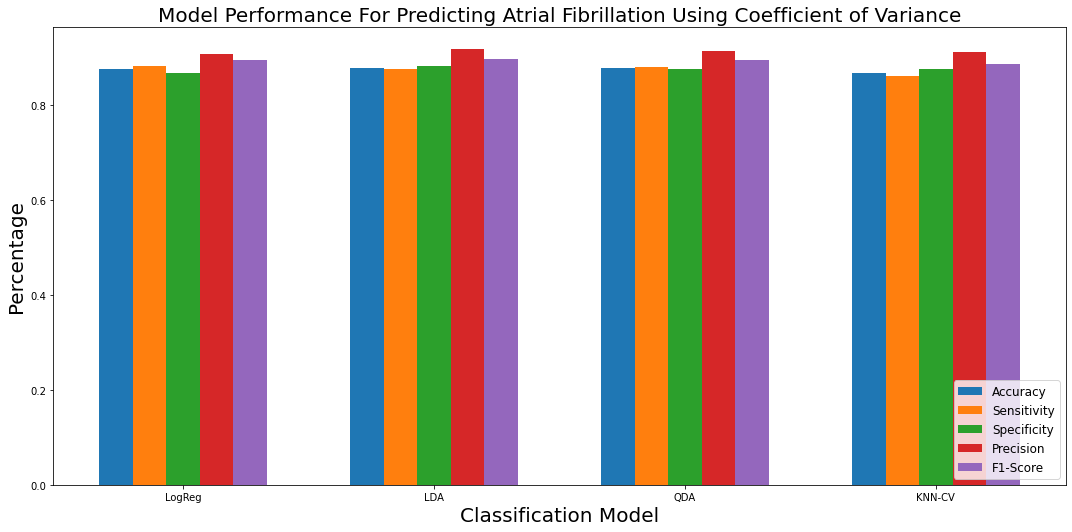

In [12]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statcoefvar_dic["Accuracy"]
sensitivities = statcoefvar_dic["Sensitivity"]
specificities = statcoefvar_dic["Specificity"]
precisions = statcoefvar_dic["Precision"]
f1_scores = statcoefvar_dic["F1-Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity')
spe = ax.bar(x,specificities, width, label='Specificity')
pre = ax.bar(x+width, precisions, width, label='Precision')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1-Score')

ax.set_xlabel('Classification Model', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using Coefficient of Variance', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 12})
plt.show()

fig.savefig('CoefVarModel.png')

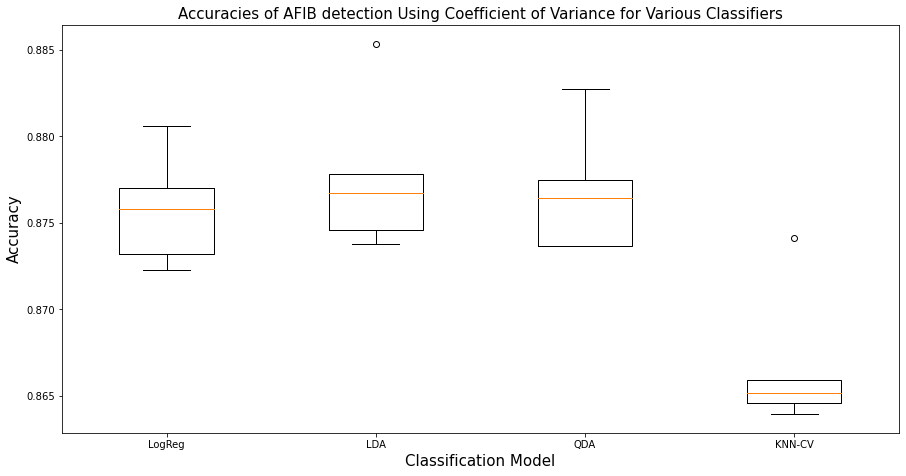

In [15]:
#Box Plots

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs['LogReg']
LDAAcc = indaccs['LDA']
QDAAcc = indaccs['QDA']
KNNAcc = indaccs['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.boxplot(data)

ax.set_title('Accuracies of AFIB detection Using Coefficient of Variance for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

fig.savefig('CoefVarBox.png')

In [18]:
coefvardf = pd.DataFrame(
    data = np.transpose(np.array([
                                statcoefvar_dic["Accuracy"],
                                statcoefvar_dic["Standard Error"],
                                statcoefvar_dic["Sensitivity"],
                                statcoefvar_dic["Specificity"],
                                statcoefvar_dic["Precision"],
                                statcoefvar_dic["F1-Score"],
                                statcoefvar_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

coefvardf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.875782,0.002953,0.882426,0.865873,0.907512,0.894793,0.374404
LDA,0.877662,0.004110,0.874961,0.881689,0.916873,0.895427,0.871637
QDA,0.876799,0.003336,0.878462,0.874319,0.912469,0.895143,1.622619
KNN-CV,0.866753,0.003739,0.860548,0.876008,0.911903,0.885481,59.987353
